# Projet Simulation et Monte Carlo : Modèle d’Ising avec bruit

_À des fins de clarté de présentation, le code d'amorçage du notebook (importation des packages, définition des fonctions non essentielles...) est situé à la fin de celui-ci. Certains codes d'estimation d'image prennent un très long temps à exécuter._


# Préalable : amorçage du notebook

#### Packages

In [23]:
 import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps
from tqdm import tqdm
import random

from scipy.stats import invgamma
from statsmodels.graphics.tsaplots import plot_acf

#### Création des différentes fonctions

In [ ]:
def tograyscale(mat):
    """
    Scale les nombres de la matrice dans [0,255] (pour permettre les images en nuance de gris)
    Mais ne prend pas encore en compte le négatif
    """
    scaled_mat = 255.0 * mat / mat.max()
    #scaled_mat[scaled_mat<0] = 0 ?
    return scaled_mat

In [ ]:
def to_binary(filename):
    """
    Importation de l'image, passage en nuance de gris, puis passage dans {0,1}
    """
    my_img = Image.open(filename)
    img_gray = ImageOps.grayscale(my_img) # Conversion en nuances de gris
    img_gray = np.array(img_gray)
    img_gray_binary = np.where(img_gray > 0.5, 1, 0) #Passage en binaire (méthodologie douteuse)
    return img_gray_binary


In [ ]:
def noise(img, TAU, MU):
    """
    Ajout d'un bruit gaussien aux pixels de l'image
    """
    img_noised = np.zeros(shape = img.shape)
    row, col = np.shape(img)
    for i in range(row):
        for j in range(col):
            # ATTENTION: scale c'est l'écart type et pas la variance !
            img_noised[i,j] = np.random.normal(loc = MU[int(img[i,j])], scale = TAU)
    
    return img_noised

In [ ]:
def sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU):
    """
    Echantillonne dans la distribution conditionnelle pour un pixel
    """
   
    # Ajout des valeurs des 4 voisins du pixel considéré, si pertinent
    voisins = []
    if i != 0:
        voisins.append(X[i-1][j])
    if i!= maxi-1:
        voisins.append(X[i+1][j])
    if j!= 0:
        voisins.append(X[i][j-1])
    if j!= maxj-1:
        voisins.append(X[i][j+1])
        
    # Calcul du nombre de 0 et de 1 dans les voisins
    nb_0 = sum(voisins[i] == 0 for i in range(len(voisins)))
    nb_1 = sum(voisins[i] == 1 for i in range(len(voisins)))
    
    # Prise en considération de la variation du nombre de voisins (bords)
    pond = 4/len(voisins) 
    
    # Calcul de la probabilité de valoir 1
    exp_valeur_1 = -ALPHA + BETA * pond * (nb_0-nb_1) + 1/(2*(TAU**2))*(MU[1]**2 - MU[0]**2 + 2*Y[i][j]*(MU[0]-MU[1]))
    
    # Calcul de la probabilité de valoir 0 (juste pour vérifier)
    #exp_valeur_0 = ALPHA + BETA * pond * (nb_1-nb_0) + 1/(2*(TAU**2))*(MU[0]**2 - MU[1]**2 + 2*Y[i][j]*(MU[1]-MU[0]))
    #print(1/(1+np.exp(exp_valeur_1)) + 1/(1+np.exp(exp_valeur_0)))
    #print(1/(1+np.exp(exp_valeur_0)))
    
    prob = 1/(1+np.exp(exp_valeur_1))
    
    # Renvoie 1 si l'uniforme est inférieure à la proba de valoir 1
    U = np.random.rand()
    return(int(U < prob)) 

In [ ]:
def get_posterior(filename0, filename, burn_in, samples, ALPHA, BETA, TAU, deter = True, MU = [0.0,1.0]):
    """
    Output les fréquences de valoir 1 pour chaque pixel
    Par défaut mu vaut [0,1] donc pas de biais
    
    Attention, ici l'image qu'on ouvre doit bien être enregistrée en nuances de gris !
    """
    
    im_open = Image.open(filename)
    Y = np.array(im_open)
    im_open.close()
    
    # Vérification que l'image est bien en nuances de gris ("2D")
    if len(Y.shape) != 2: 
        print("Erreur: l'image n'est pas en nuances de gris")
        return False
    Y = Y / 255.0 # Puisque le bruitage a été fait dans [0,1], le débruitage doit l'être aussi
    
    
    # Initialisation
    posterior = np.zeros(Y.shape) #Sortie
    
    X = np.random.choice([1,0], size = Y.shape) # Matrice X
    X_prior = X.copy() # Sauvegarde pour l'affichage plus bas
    
    maxi = Y.shape[0]
    maxj = Y.shape[1]
    pairs = []
    
    for i in range(maxi):
        for j in range(maxj):
            pairs.append((i,j))
    
    # On suit un pixel aléatoire pour vérifier la convergence
    num_ran = random.randint(0, maxi*maxj-1)
    pixel = pairs[num_ran]
    suivi_pixel = []
    
    
    
    for step in tqdm(range(burn_in + samples)):
        
        # On parcourt les pixels de manière déterministe (toujours la même)
        if deter:
            for i in range(maxi):
                for j in range(maxj):
                    x = sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU)
                    X[i,j] = x
                    if x == 1 and step >= burn_in:
                        posterior[i][j] += 1
                        
        # On parcourt les pixels de manière aléatoire
        else:
            random.shuffle(pairs) # On mélange la liste de pairs 
            for i,j in pairs:
                x = sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU)
                X[i,j] = x
                if x == 1 and step >= burn_in:
                    posterior[i][j] += 1.0
            
        suivi_pixel.append(X[pixel])
    
    # On a ajouté 1 aux pixels à chaque itération réelle où il valait 1
    # On divise par le nombre de samples pour avoir une fréquence
    posterior = posterior / samples
    
    fig, axs = plt.subplots(1, 5, figsize = (10,2))
    img_init = mpimg.imread(filename0)
    axs[0].imshow(img_init, cmap = "gray") 
    axs[0].set_title("Image d'origine")
    axs[1].imshow(Y, cmap = "gray") 
    axs[1].set_title("Image bruitée")
    axs[2].imshow(X_prior, cmap = "gray")
    axs[2].set_title("Prior aléatoire")
    axs[3].imshow(posterior, cmap = "gray")
    axs[3].set_title("Posterior")
    axs[4].scatter([i for i in range(0, len(suivi_pixel))],
        suivi_pixel, s = 2, marker = 'x')
    axs[4].set_title("Suivi pixel aléatoire")
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.05)
    
    plt.show()

    return posterior

In [ ]:
def posterior_to_binary(posterior, seuil):
    """
    Transforme notre posterior en nuances de gris en un posterior en noir et blanc
    Tout pixel valant 1 a une fréquence supérieure au seuil est considéré comme valant 1
    """
    
    if seuil < 0 or seuil > 1.0:
        print("Erreur: le seuil choisi ne correspond pas à une fréquence")
        return False 
    
    # On remplit l'image de blanc
    posterior_nb = np.ones(posterior.shape, dtype = np.float64)
    
    # On met des pixels noirs là où ils sont très peu souvent blancs
    # Comme on relève la fréquence des pixels blancs, il faut qu'on soit inférieur à un seuil
    # Cad qu'on met noirs les pixels très peu souvent blancs
    posterior_nb[posterior < seuil] = 0
    
    plt.imshow(posterior_nb, cmap = "gray")
    plt.show()
    
    return posterior_nb

In [ ]:
def sample_TAU(X, Y, maxi, maxj, TAU, MU, a, b):
    
    X_mu = np.zeros(shape = Y.shape)
    
    ##### Techniquement il faudrait remplacer chaque élément de X par la valeur correspondante du vecteur MU
    # Ici je garde MU[0] = 0 et MU[1] = 1 donc osef mais il faudra le changer 
    # Et j'imagine qu'on peut le faire d'une facon plus efficace que juste boucler sur tous les pixels
    
    somme = ((Y - X)**2).sum()
    
    a = a + (maxi*maxj)
    b = b + 1/2* somme
    TAU2 = invgamma.rvs(a = a, scale = b)
    
    return np.sqrt(TAU2), a, b

In [ ]:
def get_posterior2(filename0,filename, burn_in, samples, ALPHA, BETA, deter = True, MU = [0.0,1.0]):
    """
    Output les fréquences de valoir 1 pour chaque pixel
    Par défaut mu vaut [0,1] donc pas de biais
    
    Attention, ici l'image qu'on ouvre doit bien être enregistrée en nuances de gris !
    """
    
    im_open = Image.open(filename)
    Y = np.array(im_open)
    im_open.close()
    
    # Vérification que l'image est bien en nuances de gris ("2D")
    if len(Y.shape) != 2: 
        print("Erreur: l'image n'est pas en nuances de gris")
        return False
    Y = Y / 255.0 # Puisque le bruitage a été fait dans [0,1], le débruitage doit l'être aussi
    
    
    # Initialisation
    posterior = np.zeros(Y.shape) #Sortie
    X = np.random.choice([1,0], size = Y.shape) # Matrice X
    X_prior = X.copy() # Sauvegarde pour l'affichage plus bas
    
    a = 2 
    b = 0.5
    TAU2 = invgamma.rvs(a = a, scale = b) # On tire dans une inverse gamma pour le prior de TAU2
    TAU = np.sqrt(TAU2)
    #print(TAU)
    TAUS = [] # Liste pour vérifier la convergence de TAU
  
    maxi = Y.shape[0]
    maxj = Y.shape[1]
    pairs = []
    
    for i in range(maxi):
        for j in range(maxj):
            pairs.append((i,j))
    
    
    for step in tqdm(range(burn_in + samples)):
        
        # On parcourt les pixels de manière déterministe (toujours la même)
        if deter:
            for i in range(maxi):
                for j in range(maxj):
                    x = sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU)
                    X[i,j] = x
                    if x == 1 and step >= burn_in:
                        posterior[i][j] += 1
                     
        # On parcourt les pixels de manière aléatoire
        else:
            random.shuffle(pairs) # On mélange la liste de pairs 
            for i,j in pairs:
                x = sample(i, j, X, Y, maxi, maxj, ALPHA, BETA, TAU, MU)
                X[i,j] = x
                if x == 1 and step >= burn_in:
                    posterior[i][j] += 1.0
        
        # Mise à jour de TAU
        TAU, a, b = sample_TAU(X, Y, maxi, maxj, TAU, MU, a, b)
        if step >= burn_in:
            TAUS.append(TAU)
            
        #Mise à jour d'un pixel 
            #A completer 
            
    
    # On a ajouté 1 aux pixels à chaque itération réelle où il valait 1
    # On fait la moyenne
    posterior = posterior / samples

    fig, axs = plt.subplots(2, 3, figsize=(10,10))
    img_init = mpimg.imread(filename0)
    axs[0,0].imshow(img_init, cmap = "gray") 
    axs[0,0].set_title("Image d'origine")
    axs[0,1].imshow(Y, cmap = "gray") 
    axs[0,1].set_title("Image bruitée")
    axs[0,2].imshow(X_prior, cmap = "gray")
    axs[0,2].set_title("Prior aléatoire")
    axs[1,0].imshow(posterior, cmap = "gray")
    axs[1,0].set_title("Posterior")
    axs[1,1].plot(TAUS)
    axs[1,1].set_title("Valeur de tau")
    
    # Si on a trop peu de points, on ne peut pas calculer autant de lags
    if samples <= 10:
        lags = samples - 1
    else:
        lags = 10
        
    plot_acf(np.array(TAUS), lags = lags, ax = axs[1,2])
    axs[1,2].set_title("Autocorrélation de tau")
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.05)
    plt.show()
    
    print(np.mean(TAUS))
    return posterior


## 0. Introduction

### Méthode de Monte-Carlo par chaînes de Markov (MCMC)

Les méthodes de Monte-Carlo par chaînes de Markov (ou MCMC pour l'anglais "_Monte-Carlo Markov chains_") sont des méthodes visants à simuler une loi $\pi$ particulièrement difficile à estimer, généralement connue à une constante de renormalisation près. L'idée générale est de baser la simulation sur une chaîne de Markov $(x_t)_{t\in\mathbb{N}}$ ayant $\pi$ pour loi invariante.

### Échantillonnage de Gibbs

Si notre distribution $\pi$ admet des distributions conditionnelles faciles à générer, une option est d'utiliser l'**échantillonge de Gibbs**. L'échantillonage de Gibbs consiste à générer la loi $\pi(\mathbf{x})$ à partir des distributions $\pi(x^{(i)}|\mathbf{x}^{(-i)})$ où $x^{(i)}$ est la $i$-ème composante de $\mathbf{x}$ et $\mathbf{x}^{(-i)}$ le vecteur privé de cette $i$-ème composante.

Supposons que $\mathbf{x}$ possède $p \in \mathbb{N}_\star$ composantes. L'algorithme est plus simple qu'il n'y paraît: à partir d'un état initial $\mathbf{x}_0$, on génère sucessivement à chaque étape $n$:

1. $\forall i \in [\!\![1,p]\!\!],$ répéter:
    
    - générer $x_{n+1}^{(i)} \sim \pi(\cdot|\mathbf{x}^{(0:i-1)}_{n+1},\mathbf{x}^{(i+1:p)}_{n})$

... où $\mathbf{x}^{(a:b)}$ représente les composantes de $a$ à $b$ de $\mathbf{x}$.

On remarque qu'il n'est nécessaire de connaître $\pi$ qu'**à une constante multiplicative près**, puisque: $$\pi(x^{(i)}|\mathbf{x}^{(-i)})=\frac{\pi(\mathbf{x})}{\int \pi(\mathbf{x}^{(0:i-1)}, dx^{(i)},\mathbf{x}^{(i+1:p)})}=\frac{\cancel{k} \pi^\star(\mathbf{x})}{\cancel{k} \int \pi^\star(\mathbf{x}^{(0:i-1)}, dx^{(i)},\mathbf{x}^{(i+1:p)})}$$
... où $ \pi = k \pi^\star$

On remarque également que (1) les compostantes $x^{(i)}$ peuvent également être tirée conjointement, si la loi jointe le permet ; et que (2) l'ordre des composantes n'a pas d'importance.

L'échantillonage de Gibbs est particulièrment utilisé pour les méthode bayésiennes, comme c'est le cas dans notre exercice.

### Et le débruitage dans tout ça ?

Dans notre contexte, l'idée est la suivante. Nous avons une image bruité, en nuances de gris, dont nous supposons qu'elle a été une image en noir et blanc (au sens strict: soit noir, soit blanc). Nous supposons également que, comme beaucoup d'images "normales", des pixels avoisinants ont une grande probabilité d'être de la même couleur, autrement dit que les images avec des tâches noires et blanches sont plus probables que les images pixels blancs et noirs se succèdent de façon rapprochée.

Pour traduire ces hypothèses, nous supposons que l'image originale est l'image $\mathbf{x}$ composée de pixels $x^{(i)}$ suit une **loi d'Ising**. (Cette loi vient de la physique statistique, et vise initialement à décrire le _spin_ des électrons, qui s'influence par voisinage de sorte que dans un voisinage donné on trouve rarement des électrons de _spin_ différent. Cela correspond bien à notre description précédent des images.)


$$ p(x)=\frac{1}{Z\left(\alpha, \beta \right)} \exp \left[\alpha \sum_{i} x_{i}+\beta \sum_{i=j} \mathbb{1}\left[x_{i}=x_{j}\right]\right\}$$

Ensuite, on suppose qu'il existe un phénomène de bruitage $y^{(i)}|x^{(i)}=k \sim \mathscr{N}(\mu_k, \tau)$ où $k=0$ ou $1$ et $\tau$ est tantôt connu (question 1) ou estimé (question 2) et où $0<\mu_0<\mu_1<1$ sont supposés connus. $\mathbf{y}$ note l'image bruitée entière et on supposera $y^{(i)}\in[0,1]$ même si cela en théoriquement faux (le support d'une loi normale est de 1).

Retrouver l'image originale, dans notre contexte, c'est juste savoir simuler $\hat{\mathbf{x}} \sim \mathbf{x}|\mathbf{y}$, ce qui permet donc complètement d'utiliser l'échantillonage de Gibbs présenté à l'instant. Cela peut paraître étrange de "décoder" une image par un processus de génération aléatoire mais:

1. cela permet de mettre en lumière le caractère arbitraire d'une reconstitution d'image $\hat{\mathbf{x}}$ donnée (la simulation permet de générer plusieurs images candidates)
2. en pratique, l'image bruitée $\mathbf{y}$ contraint très fortement la loi conditionnelle $\mathbf{x}|\mathbf{y}$ de sorte que la variance des résultats est très faible, et se rapproche ainsi presque d'un débruitage déterministe

Notons enfin que **la constante $Z(\alpha,\beta)$ est non estimable en pratique**. La calculer explicitement nécessite en effet une disjonction sur toutes les images possibles, qui sont au nombre de $2^{(lL)}$, où $(l,L)$ sont la largeur et la longueur d'une image en pixels. Cela rend l'échantillonage de Gibbs d'autant plus intéressant dans ce cas.

## 1. Échantillonnage de Gibbs dans le cas où $\tau$, $\mu_0$, $\mu_1$, $\alpha$, $\beta$ sont connus

### 1.1 Théorie

Soit $y_{i}$ le niveau de gris du pixel $i$ et les $x_{i} \in \{0,1\}$, vraie valeur d'un pixel blanc ou noir, suivant une loi d'Ising :  
$$ p(x)=\frac{1}{Z\left(\alpha, \beta \right)} \exp \left[\alpha \sum_{i} x_{i}+\beta \sum_{i=j} \mathbb{1}\left[x_{i}=x_{j}\right]\right\}$$

On considère le modèle de la forme : $ y_{i} \mid x_{i}=k \sim \mathcal{N}\left(\mu_{k}, \tau^{2}\right) $

On veut calculer  $\mathbb{P}(X \mid Y) = \frac{\mathbb{P}(Y \mid X) \mathbb{P}(X)}{\mathbb{P}(Y)} = \frac{\mathbb{P}(X \cap Y)}{\mathbb{P}(Y)}  $

On génère les pixels un par un. Comme les $x_{i}$ ne peuvent prendre que deux valeurs, à savoir 0 ou 1, $X$ suit une loi de Bernouilli dont on cherche à déterminer le paramètre. 

$ y_{i} \mid x_{i}=k \sim \mathcal{N}\left(\mu_{k}, \tau^{2}\right) $ donc $\mathbb{P}(y_{i} \mid x_{i} = k) = \frac{1}{\sqrt{2\pi \tau^{2}}} exp \{\frac{-1}{2\tau^{2}} \left(y_{i} - \mu_{k}\right)^{2} \} $

Par la formule des probabilités totales et de Bayes, on a : $\mathbb{P}(X_{i} =1 \mid Y_{i}, X_{i}) = \frac{\mathbb{P}(X_{i} = 1 \cap Y_{i}, X_{i})}{\sum_{x_{i} \in \{0,1\}} \mathbb{P}(X_{i} = x_{i} \cap Y_{i}, X_{i})}$

$ \mathbb{P}(X_{i} =1 \mid Y_{i}, X_{i}) = \frac{\frac{1}{Z\left(\alpha, \beta \right)} \frac{1}{\sqrt{2\pi \tau^{2}}} exp\{ \alpha \sum_{i} x_{i} + \beta \mathbb{1} \{ x_{j} = 1 \} - \frac{1}{2 \tau^{2}} \left(y_{i} - \mu_{1} \right)^{2} \}  }{\sum_{x_{i} \in \{0,1\}} \frac{1}{Z\left(\alpha, \beta \right)} \frac{1}{\sqrt{2\pi \tau^{2}}} exp\{ \alpha \sum_{i} x_{i} + \beta \mathbb{1} \{ x_{j} = 1 \} - \frac{1}{2 \tau^{2}} \left(y_{i} - \mu_{k}(x_{i}) \right)^{2} \} }  $ 


En divisant en haut et en bas par le numérateur, on obtient : $ \mathbb{P}(X_{i} =1 \mid Y_{i}, X_{i}) = \frac{1}{1 + exp(N)} $ avec 

$ N =  -\alpha + \beta \sum_{j} [ \mathbb{1} \{ x_{j} = 0 \} - \mathbb{1}\{  x_{j} = 1 \} ] - \frac{1}{2\tau^{2}} \left(y_{i} - \mu_{0}\right)^{2} + \frac{1}{2\tau^{2}} \left(y_{i} - \mu_{1}\right)^{2} $

$ N = \frac{1}{2\tau^{2}} \left[ \left(y_{i}^2 - 2\mu_{1} y_{i} + \mu_{1}^2) - (y_{i}^2 - 2\mu_{0} y_{i} + \mu_{0}^2 \right) \right] $ 

$ N = \frac{1}{2\tau^{2}} \left[ \mu_{1}^{2} - \mu_{0}^{2} + 2 y_{i} \left(\mu_{0} - \mu_{1}\right) \right] $ 

Finalement, on obtient : 

$ \mathbb{P}(X_{i} = 1 \mid Y_{i}, X_{i}) = \frac{1}{1 + exp \{ -\alpha + \beta \sum_{j} [ \mathbb{1} \{ x_{j} = 0 \} - \mathbb{1}\{  x_{j} = 1 \} ] + \frac{1}{2\tau^{2}} \left[ \mu_{1}^{2} - \mu_{0}^{2} + 2 y_{i} \left(\mu_{0} - \mu_{1}\right) \right] \} }$

De plus, comme $\mathbb{P}(X_{i} = 0 \mid Y_{i}, X_{i}) = 1 - \mathbb{P}(X_{i} = 1 \mid Y_{i}, X_{i}) $

De la même manière, on obtient :  $ \mathbb{P}(X_{i}=0 \mid Y_{i}, X_{i}) = \frac{1}{1 + exp \{ \alpha + \beta \sum_{j} [ \mathbb{1} \{ x_{j} = 0 \} - \mathbb{1}\{  x_{j} = 1 \} ] + \frac{1}{2\tau^{2}} \left[ 2y_{i} (\mu_{1} - \mu_{0}) + (\mu_{0}^{2} - \mu_{1})^{2} \right]  \} } $ 





### Algorithme de Metropolis-Hasting

Soit une chaîne de Markov dont la tansition $x \to y$ a pour probabilité $g(y|x)$ (avec $g$ connue et facilement échantillonable) et soit $x_0$ un point de départ. Pour chaque étape $n$:

1. Générer une variable $y \sim g(.|x_{n})$
2. Calculer $r=\frac{\pi(\;y\,)g(\;y\,|x_n)}{\pi(x_n)g(x_n|\;y\,)}$. Générer une variable $u\sim\mathscr{U}[0,1]$. Poser $x_{n+1}=y$ si $u \leqslant r$, ou retourner à (1) sinon.

Intuitivement, cette la suite $(x_n)$ converge bien en loi vers $\pi$ puisqu'on accepte toujours de se déplacer vers les états $y$ plus probables (selon $\pi$) que l'état actuel $x_n$. Néanmoins, on accepte avec une certaine probabilité $r$ de se déplacer vers un état $y$ moins probable, afin de bien visiter tout l'espace surlequel $\pi$ est définie.

On remarque — c'est important en pratique — que le calcul de $r$ ne nécessite de connaître $\pi$ qu'**à une constante multiplicative près**, et c'est tout l'intérêt de cette algorithme.

Lorsque l'espace surlequel $\pi$ est défini devient grand, chaque transition $\mathbf{x} \to \mathbf{y}$ (où nous utilisons le gras pour souligner le caractère vectoriel des variable) devient moins probable, de sorte que l'algorithme de Metropolis-Hasting devient lent puisque de très nombreux états $\mathbf{x}_t$ doivent être traversés afin de converger vers $\pi$.


#### 1.1.1 Dérivation théorique de $p(x^{(i)}|\mathbf{x}^{(-i)},\mathbf{y})$

Soit $y_{i}$ le niveau de gris du pixel $i$ et les $x_{i} \in \{0,1\}$, vraie valeur d'un pixel blanc ou noir, suivant une loi d'Ising :  
$$ p(x)=\frac{1}{Z\left(\alpha, \beta \right)} \exp \left[\alpha \sum_{i} x_{i}+\beta \sum_{i=j} \mathbb{1}\left[x_{i}=x_{j}\right]\right\}$$

On considère le modèle de la forme : $ y_{i} \mid x_{i}=k \sim \mathcal{N}\left(\mu_{k}, \tau^{2}\right) $

On veut calculer  $\mathbb{P}(X \mid Y) = \frac{\mathbb{P}(Y \mid X) \mathbb{P}(X)}{\mathbb{P}(Y)} = \frac{\mathbb{P}(X \cap Y)}{\mathbb{P}(Y)}  $

On génère les pixels un par un. Comme les $x_{i}$ ne peuvent prendre que deux valeurs, à savoir 0 ou 1, $X$ suit une loi de Bernouilli dont on cherche à déterminer le paramètre. 

$ y_{i} \mid x_{i}=k \sim \mathcal{N}\left(\mu_{k}, \tau^{2}\right) $ donc $\mathbb{P}(y_{i} \mid x_{i} = k) = \frac{1}{\sqrt{2\pi \tau^{2}}} exp \{\frac{-1}{2\tau^{2}} \left(y_{i} - \mu_{k}\right)^{2} \} $

Par la formule des probabilités totales et de Bayes, on a : $\mathbb{P}(X_{i} =1 \mid Y_{i}, X_{i}) = \frac{\mathbb{P}(X_{i} = 1 \cap Y_{i}, X_{i})}{\sum_{x_{i} \in \{0,1\}} \mathbb{P}(X_{i} = x_{i} \cap Y_{i}, X_{i})}$

$ \mathbb{P}(X_{i} =1 \mid Y_{i}, X_{i}) = \frac{\frac{1}{Z\left(\alpha, \beta \right)} \frac{1}{\sqrt{2\pi \tau^{2}}} exp\{ \alpha \sum_{i} x_{i} + \beta \mathbb{1} \{ x_{j} = 1 \} - \frac{1}{2 \tau^{2}} \left(y_{i} - \mu_{1} \right)^{2} \}  }{\sum_{x_{i} \in \{0,1\}} \frac{1}{Z\left(\alpha, \beta \right)} \frac{1}{\sqrt{2\pi \tau^{2}}} exp\{ \alpha \sum_{i} x_{i} + \beta \mathbb{1} \{ x_{j} = 1 \} - \frac{1}{2 \tau^{2}} \left(y_{i} - \mu_{k}(x_{i}) \right)^{2} \} }  $ 


En divisant en haut et en bas par le numérateur, on obtient : $ \mathbb{P}(X_{i} =1 \mid Y_{i}, X_{i}) = \frac{1}{1 + exp(N)} $ avec 

$ N =  -\alpha + \beta \sum_{j} [ \mathbb{1} \{ x_{j} = 0 \} - \mathbb{1}\{  x_{j} = 1 \} ] - \frac{1}{2\tau^{2}} \left(y_{i} - \mu_{0}\right)^{2} + \frac{1}{2\tau^{2}} \left(y_{i} - \mu_{1}\right)^{2} $

$ N = \frac{1}{2\tau^{2}} \left[ \left(y_{i}^2 - 2\mu_{1} y_{i} + \mu_{1}^2) - (y_{i}^2 - 2\mu_{0} y_{i} + \mu_{0}^2 \right) \right] $ 

$ N = \frac{1}{2\tau^{2}} \left[ \mu_{1}^{2} - \mu_{0}^{2} + 2 y_{i} \left(\mu_{0} - \mu_{1}\right) \right] $ 

Finalement, on obtient : 

$ \mathbb{P}(X_{i} = 1 \mid Y_{i}, X_{i}) = \frac{1}{1 + exp \{ -\alpha + \beta \sum_{j} [ \mathbb{1} \{ x_{j} = 0 \} - \mathbb{1}\{  x_{j} = 1 \} ] + \frac{1}{2\tau^{2}} \left[ \mu_{1}^{2} - \mu_{0}^{2} + 2 y_{i} \left(\mu_{0} - \mu_{1}\right) \right] \} }$

De plus, comme $\mathbb{P}(X_{i} = 0 \mid Y_{i}, X_{i}) = 1 - \mathbb{P}(X_{i} = 1 \mid Y_{i}, X_{i}) $

De la même manière, on obtient :  $ \mathbb{P}(X_{i}=0 \mid Y_{i}, X_{i}) = \frac{1}{1 + exp \{ \alpha + \beta \sum_{j} [ \mathbb{1} \{ x_{j} = 0 \} - \mathbb{1}\{  x_{j} = 1 \} ] + \frac{1}{2\tau^{2}} \left[ 2y_{i} (\mu_{1} - \mu_{0}) + (\mu_{0}^{2} - \mu_{1})^{2} \right]  \} } $ 




#### 1.1.2 Algorithme

Notons que le temps d'exécution de l'algorithme est proportionnel au nombre de pixels de l'image, et donc au carré de la résolution. Cela est une mauvaise nouvelle pour les images de grande taille.

### 1.2 Application

#### 1.2.0 : Un préalable : pixel blanc ou pixel noir ? 

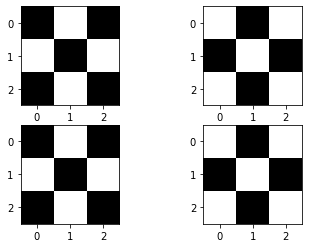

In [25]:
matrix_color = [np.array([[0,1,0],[1,0,1],[0,1,0]]),
                np.array([[1,0,1],[0,1,0],[1,0,1]]),
                np.array([[0,255,0],[255,0,255],[0,255,0]]),
                np.array([[255,0,255],[0,255,0],[255,0,255]])]
fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(matrix_color[0], cmap = "gray") 
axs[0,1].imshow(matrix_color[1], cmap = "gray")
axs[1,0].imshow(matrix_color[2], cmap = "gray")
axs[1,1].imshow(matrix_color[3], cmap = "gray")
plt.show()

Donc, nous avons la classification suivante

0 = pixel noir

1 (si 0/1) ou 255 (si 0/255) = pixel blanc

#### 1.2.1 Génération d'images bruitées

**Images initiales**

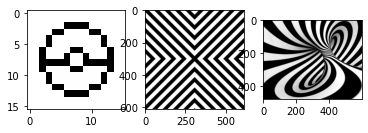

In [11]:
f, axarr = plt.subplots(1,3)
img  = mpimg.imread("data/poke.png")     # petite
img2 = mpimg.imread("data/triangle.png") # moyenne
img3 = mpimg.imread("data/spirale.png")  # grande
axarr[0].imshow( img, cmap="gray")
axarr[1].imshow(img2, cmap="gray")
axarr[2].imshow(img3, cmap="gray")
plt.show() # TO DO: plus grandes images ?

**Bruitage**

Pour le bruitage, on utilise le fait que par hypothèse l'image bruitée $\mathbf{y}$ est telle que chaque pixel $x^{(i)}\in \{0,1\}$ est bruité par une loi normale $y^{(i)} | x^{(i)}=k \sim \mathscr{N}(\mu_k,\tau^2)$ où $\tau$ et $0<\mu_0<\mu_1<1$ sont choisis de telle sorte que la probabilité que $y^{(i)} \not\in [0,1]$ soit quasi-nulle.

In [1]:
def create_noised_image(img, name, TAU, MU = [0,1]): # TO DO : j'ai une question sur MU=[0,1]
    """
    img = chemin vers l'image à bruiter
    name = suffixe de l'image bruitée enregistrée
    TAU = écart-type pour le bruit gaussien
    MU = moyenne pour le bruit gaussien MU[0] = 0, MU[1] = 1 par défaut donc bruit centré
    Pour faire un autre bruit MU[0] correspond au biais des pixels valant 0 dans l'image d'origine
    MU[1] correspond au biais valant 1 dans l'image d'origine
    """
    
    img_bin = to_binary(img) # Vu que l'image originale doit être dans [0,1], on force les pixels à ne valoir qu'une 
    # seule de ces valeurs
    img_bin_noised = noise(img_bin, TAU, MU)
    plt.imshow(img_bin_noised, cmap = "gray") # TO DO: comment ?
    
    tosave = Image.fromarray(tograyscale(img_bin_noised))
    #tosave.convert("L").save("data/"+str(name)+"_TAU="+str(TAU)+".png")
    img_name = "data/"+str(name)+"_TAU="+str(TAU)+ "_MU="+str(MU[0])+"_"+str(MU[1])+".png"
    print(img_name) # TO DO: comment ?
    tosave.convert("L").save(img_name)

**Images modérément bruitées** ($\tau=0{,}1$)

data/poke_noise_TAU=0.1_MU=0_1.png


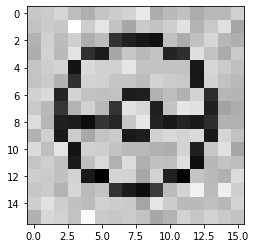

data/triangle_noise_TAU=0.1_MU=0_1.png


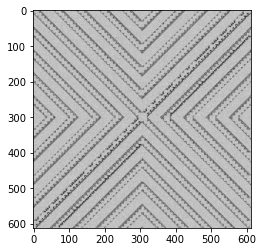

data/spirale_noise_TAU=0.1_MU=0_1.png


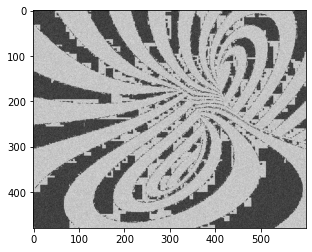

In [19]:
create_noised_image("data/poke.png", "poke_noise", TAU= 0.1)
plt.show()
create_noised_image("data/triangle.png", "triangle_noise", TAU= 0.1)
plt.show()
create_noised_image("data/spirale.png", "spirale_noise", TAU= 0.1)
plt.show()

# TO DO: même format qu'au-dessus ?

**Image plus fortement bruitées** ($\tau=0{,}2$)

data/poke_noise_TAU=0.2_MU=0_1.png


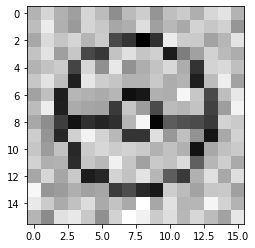

data/triangle_noise_TAU=0.2_MU=0_1.png


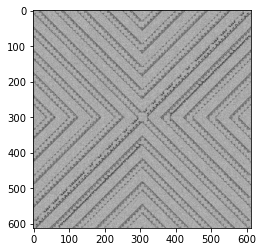

data/spirale_noise_TAU=0.2_MU=0_1.png


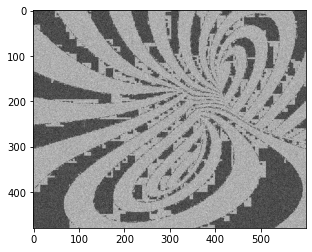

In [12]:
create_noised_image("data/poke.png", "poke_noise", TAU= 0.2)
plt.show()
create_noised_image("data/triangle.png", "triangle_noise", TAU= 0.2)
plt.show()
create_noised_image("data/spirale.png", "spirale_noise", TAU= 0.2)
plt.show()
# TO DO: même format qu'au-dessus ?

#### 1.2.2 Estimation des images initiales

**Images modérément bruitées** ($\tau=0{,}1$)

Avec un écart-type de 0.1, on arrive à débruiter en une seule étape

100%|██████████| 1/1 [00:00<00:00, 125.76it/s]


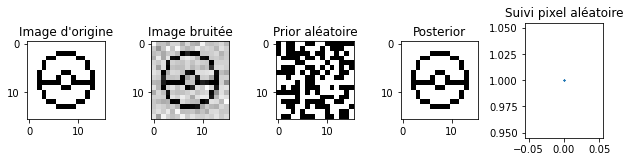

In [18]:
posterior_poke = get_posterior("data/poke.png", "data/poke_noise_TAU=0.1_MU=0_1.png", 0, 1, ALPHA = 1e-5, 
                               BETA = 0.2, TAU = 0.1, deter = True)
plt.show()

100%|██████████| 1/1 [00:11<00:00, 11.61s/it]


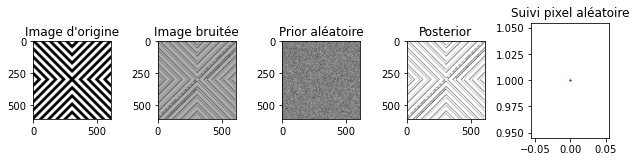

100%|██████████| 1/1 [00:08<00:00,  8.65s/it]


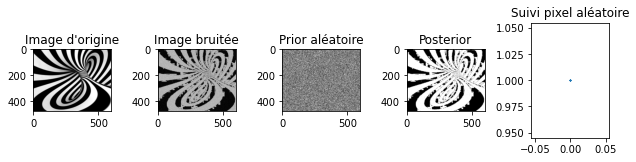

In [19]:
posterior_triangle = get_posterior("data/triangle.png","data/triangle_noise_TAU=0.1_MU=0_1.png", 0, 1, ALPHA = 1e-5, BETA = 0.2, TAU = 0.1, 
                          deter = True)
plt.show()
posterior_spirale = get_posterior("data/spirale.png","data/spirale_noise_TAU=0.1_MU=0_1.png", 0, 1, ALPHA = 1e-5, BETA = 0.2, TAU = 0.1, 
                          deter = True)
plt.show()

**Image plus fortement bruitées** ($\tau=0{,}2$)

Avec un écart type plus élevé, ça se complique, mais en filtrant les probas selon un seuil, on peut quand même retrouver l'image de base ! Ici, les pixels noirs sont les pixels qui ne sont pas blancs 99% du temps.

100%|██████████| 110/110 [00:00<00:00, 124.16it/s]


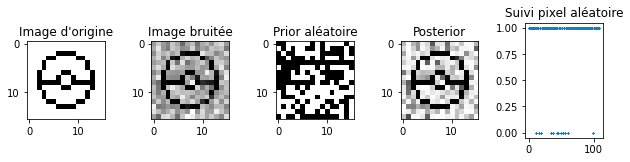

In [20]:
posterior_poke_tau_eleve = get_posterior("data/poke.png","data/poke_noise_TAU=0.2_MU=0_1.png", 10, 100, ALPHA = 0.01, BETA = 0.01, TAU = 0.3, 
                          deter = False)
plt.show()

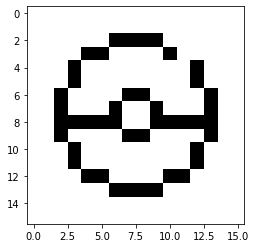

In [22]:
post_nb = posterior_to_binary(posterior_poke_tau_eleve, seuil = 0.1)
plt.show()

100%|██████████| 15/15 [02:58<00:00, 11.90s/it]


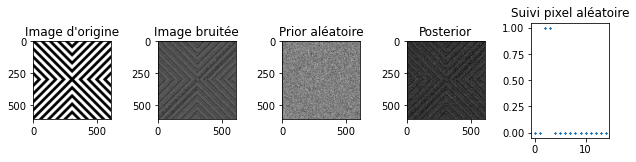

100%|██████████| 15/15 [02:22<00:00,  9.49s/it]


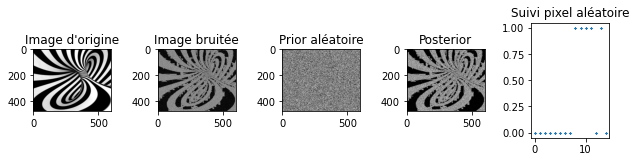

In [21]:
posterior_triangle_tau_eleve = get_posterior("data/triangle.png","data/triangle_noise_TAU=0.4_MU=0_1.png", 5, 10, ALPHA = 0.01, BETA = 0.01, TAU = 0.3, 
                          deter = False)
plt.show()
posterior_spirale_tau_eleve = get_posterior("data/spirale.png","data/spirale_noise_TAU=0.2_MU=0_1.png", 5, 10, ALPHA = 0.01, BETA = 0.01, TAU = 0.3, 
                          deter = False)
plt.show()

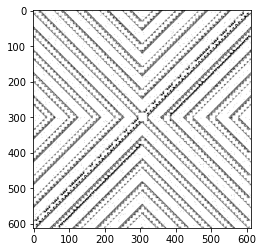

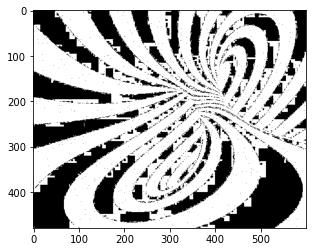

In [ ]:
post_nb2 = posterior_to_binary(posterior_triangle, seuil = 0.1)
plt.show()
post_nb3 = posterior_to_binary(posterior_spirale, seuil = 0.1)
plt.show()

#### 1.2.3 Étude de la robustesse

TO DO: ne pas rentrer dans les détails, juste lister les conclusions

## 2. Échantillonnage de Gibbs dans le cas où $\tau$ est inconnu

### 2.1 Théorie

Si nous supposons $\tau$ inconnu avec une "loi _a priori_" $p(\tau)$ comme suggéré, c'est que nous nous plaçons dans le cadre bayésien. Estimer $\tau$, c'est donc avant tout estimer la loi _a posterioti_ $p(\tau|\mathbf{y})$. Or justement, l'échantillonnage nous certes principalement $p(\mathbf{x},\tau|\mathbf{y})$, mais aussi $p(\tau|\mathbf{y})$ (en se restreignant aux générations de $\tau$). Attention, même s'il y a convergence de la fonction de répartition empirique, il n'y a pas indépendance entre les valeurs de $\tau_n$ successive.

La première étape de l'algorithme est inchangé. On réécrit juste $p(\mathbf{x}|\mathbf{y},\tau):=p(\mathbf{x}|\mathbf{y})$ pour souligner que désormais $\tau$ est considéré comme une variable aléatoire. En revanche, mettre à jour $\tau_n$ à chaque itération nécessite d'expliciter $p(\tau|\mathbf{x},\mathbf{y})$ et de choisit une valeur initiale $\tau_0$.

#### 2.1.1 Dérivation de $p(\tau|\mathbf{x},\mathbf{y})$ et choix de $p(\tau)$

On montre que si on utilise un _a priori_ inverse-gamma $\mathcal{IG}$ sur $\tau^2$:

$$\tau^2 \sim \mathcal{IG}(a,b)$$

... alors:

$$p(\tau^2 \mid \mathbf{x},\mathbf{y}) \sim \mathcal{IG}( a + n , b + \frac{1}{2} \sum_i\left(y^{(i)}-\mu_{x^{(i)}}\right)^{2})$$ 

**Démonstration**

On rappelle tout d'abord la loi Inverse-Gamma:

$p(\tau^2)=\frac{b^{a}}{\Gamma(a)}(1 / \tau^2)^{a+1} \operatorname{exp}(-b / \tau^2) \propto \left(\tau^{2}\right)^{-(a+1)}\operatorname{exp}(-b / \tau^2)$

... ainsi que la loi d'Ising:

$p(\mathbf{x})$

Ensuite : **#TODO il y a un pb dans la dérivation, il faut se débarasser des $y$ et là c'est pas clair.**

$$
p(\tau^2 \mid \mathbf{x}, \mathbf{y}) = \frac{p(\tau^2, \mathbf{x}, \mathbf{y})}{ \underbrace{ \int_{0}^\infty p(\tau^2,\mathbf{x}, \mathbf{y})d\tau^2}_{ \text{ne dépend pas de }\tau} } \\
\propto p(\tau^2, \mathbf{x}, \mathbf{y})=p(\tau^2) \times p(\mathbf{x}, \mathbf{y} \mid \tau^2) \\
\propto \left(\tau^{2}\right)^{-n}\left(\tau^{2}\right)^{-(a+1)} \times {exp}\left\{-\frac{1}{2 \tau^{2}} \sum\left(y^{(i)}-\mu_{x^{(i)}}\right)^{2}-\frac{b}{\tau^{2}}\right\} \\
\propto \left(\tau^{2}\right)^{-(a+n+1)} \exp \left\{-\frac{1}{\tau^{2}}\left(\frac{1}{2} \sum\left(y^{(i)}-\mu_{x^{(i)}})^{2}+b)\right\}\right.\right.
$$

#### 2.1.2 Adaptation de l'algoirhtme

### 2.2 Application

### Estimation de l'image initiale (en supposant $\tau$ inconnu) et estimation de la convergence de $\tau$ 

#### Image faiblement bruitée ($\tau=0.1$)

In [ ]:
posterior_qst2_poke = get_posterior2("data/poke.png","data/poke_noise_TAU=0.1_MU=0_1.png", 1000, 100, ALPHA = 0.2, BETA = 0.2,  
                          deter = True)
plt.show()

In [ ]:
posterior_qst2_poke = get_posterior2("data/poke.png","data/poke_noise_TAU=0.1_MU=0_1.png", 1000, 100, ALPHA = 0.2, BETA = 0.2,  
                          deter = True)
plt.show()
posterior_qst2_triangle = get_posterior2("data/triangle.png","data/triangle_noise_TAU=0.1_MU=0_1.png", 5, 10, ALPHA = 0.2, BETA = 0.2,  
                          deter = True)
plt.show()
posterior_qst2_spirale = get_posterior2("data/spirale.png","data/spirale_noise_TAU=0.1_MU=0_1.png", 5, 10, ALPHA = 0.2, BETA = 0.2,  
                          deter = True)
plt.show()

#### Image plus fortement bruitée ($\tau=0.2$)

In [ ]:
posterior_qst2_poke_taux_int = get_posterior2("data/poke.png","data/poke_noise_TAU=0.2_MU=0_1.png", 1, 100, ALPHA = 0.2, BETA = 0.2,  
                          deter = True)
plt.show()

In [ ]:
posterior_qst2_triangle_taux_int = get_posterior2("data/triangle.png","data/triangle_noise_TAU=0.2_MU=0_1.png", 5, 10, ALPHA = 0.2, BETA = 0.2,  
                          deter = True)
plt.show()
posterior_qst2_spirale_taux_int = get_posterior2("data/spirale.png","data/spirale_noise_TAU=0.2_MU=0_1.png", 5, 10, ALPHA = 0.2, BETA = 0.2,  
                          deter = True)
plt.show()

De nos expériences, nous retenons que:

* On retrouve relativement bien l'image de base

* On ne retombe pas tout à fait sur l'écart-type d'origine (et changer $\alpha$ ou $\beta$ ne semble pas régler le problème)

## 3. Impossible échantillonnage de Gibbs dans le cas où $\alpha$ et $\beta$ sont inconnus

Pour "estimer" $(\alpha,\beta)$ dans le paradigme bayésien, on se donne une loi _a priori_ $p(\alpha,\beta)$ sur le couple, et on calcule la loi _a posteriori_ $p(\alpha,\beta|\mathbf{y})$. Or c'est précisément ce que nous donne l'échantillonnage de Gibbs: la capacité de générer des nombres selon la loi jointe $p(\mathbf{x},\tau,\alpha,\beta|\mathbf{y})$. Les étapes précédentes sont inchangées puisque:

1. on remplace la notation $p(x)$ par $p(x|\alpha,\beta)$ (puisque les $(\alpha, \beta)$) sont des variables aléatoires maintenant, mais le reste de l'étape (1) est inchangé car $(\alpha,\beta) \perp \!\! \perp \mathbf{y} |\mathbf{x}$
2. $(\alpha,\beta) \perp \!\! \perp \tau$ donc l'étape (2) est inchangée

Il mous manque uniquement une troisième étape permettant à chaque cycle de mettre à jour $(\alpha_{n+1},\beta_{n+1})$ à partir de $p(\alpha, \beta \mid \mathbf{x}_n, \mathbf{y}_n,\tau_n)$. On pourrait penser que, ayant toute lattitude pour le choix de $p(\alpha,\beta)$, on serait à même de choisir une loi particulière de telle sorte que $p(\alpha, \beta \mid \mathbf{x}_n, \mathbf{y}_n,\tau_n)$ facilement échantillonable.

Malheureusement, ce n'est pas le cas. Concentrons-nous sur $\alpha$ seul pour voir pourquoi.

$$
p(\alpha \mid \mathbf{x}, \mathbf{y},\tau)\overset{\text{indé.}}{=}p(\alpha \mid \mathbf{x}) = \frac{p(\alpha, \mathbf{x})}{p(\mathbf{x})}=\frac{p(\alpha, \mathbf{x})}{\underbrace{ \int p(d \alpha, \mathbf{x})}_{\text{ne dépend pas de }\alpha}}\propto p(\boldsymbol{x} \mid \alpha) p(\alpha) \propto \frac{\exp \left\{\alpha \sum_{i} x_{i}\right\}}{Z(\alpha, \beta)}p(\alpha) 
$$

... or l'expression $Z(\alpha,\beta)$, qui était une constante par rapport à $\mathbf{x}$, ne l'est plus du tout par rapport à $\alpha$. Et de plus, nous avons vu en introduction qu'elle n'est pas estimable!